In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy
from skimage.transform import resize


plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
print(torch.cuda.device_count())


Using CUDA
1


In [2]:
device = 'cuda'

In [3]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle1.json to kaggle1.json


{'kaggle1.json': b'{"username":"rishabh0100","key":"a75857b2a6d6d5966260b826f5322b27"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/      #to use kaggle datasets

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d datamunge/sign-language-mnist

 99% 62.0M/62.6M [00:02<00:00, 16.7MB/s]
100% 62.6M/62.6M [00:02<00:00, 28.9MB/s]


In [7]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [8]:
torch.set_default_tensor_type('torch.FloatTensor')

In [9]:
class HandDetectionDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    self.data = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
      return len(self.data)  

  def __getitem__(self,idx):                     #converting to images of size 28x28 and storing it in example folder
    img_name = self.data.iloc[idx, 0]
    
    pixels = self.data.iloc[idx, 1:]
    pixels = np.asarray(pixels)                              
    image = pixels.astype(np.float32).reshape(28,28) 
    p = transforms.Compose([transforms.Resize((224,224))])
    
    image = resize(image, (224, 224))
    #image = pixels.reshape(28,28)
    # if(img_name <= 5):                           #trying to give as data only 6 classes other will be returned as NULL
    #file_name=f"example/image_{idx}.jpg"            #seperating the images and their names after getting raw data from the website
    #cv2.imwrite(file_name,pixels)                 # Returns the images as sample file with image and label seperate
    #image = cv2.imread(file_name)
    #dim = np.zeros((28,28))
    image = np.stack((image,image, image), axis=2);
    image = image.transpose((2, 0, 1));
    image = torch.from_numpy(image);
  
    #img_name =  torch.from_numpy(img_name)
    sample = {'image': image, 'label': img_name}
    #if torch.is_tensor(image):
      #rint(type(sample['image']))
      #print(sample['image'])

    if self.transform:
      sample = self.transform(sample)     # We import the transform function from torchvision.transforms
  
    return sample
    # else:
    #   pass        

device = 'cuda'
print(device)

cuda


In [10]:
train_dataset = HandDetectionDataset(csv_file='sign_mnist_train.csv')

In [11]:
test_dataset = HandDetectionDataset(csv_file='sign_mnist_test.csv')

In [12]:
dataloader_test = DataLoader(test_dataset, batch_size = 10, shuffle =True, num_workers=0)

In [13]:
dataloader_train = DataLoader(train_dataset, batch_size=10,
                        shuffle=True, num_workers=0)

In [14]:
def imshow(inp, title=None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    
    inp = inp.astype('int')

    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=classes)


print((next(iter(dataloader_train))['label']))


tensor([ 7,  4, 11,  5, 20,  6,  6,  8,  3,  7])


In [15]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for dummy,data in enumerate(dataloader_train):
        inputs, labels = data['image'], data['label']
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        print(outputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [16]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloader_train)
    print("Evaluating model")
    print('-' * 10)
    
    i=1

    for  dummy,data in enumerate(dataloader_train):
        
        
        print("\rTest batch {}/{}".format(i, test_batches/10), end='', flush=True)

        if i>((test_batches)/10):
          break
        
        i = i+1
        vgg.train(False)
        vgg.eval()
        inputs, labels = data['image'], data['label']

        #if use_gpu:
        inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        #else:
         #   inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        print(preds)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test /i
    avg_acc = acc_test / i
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [23]:
vgg16 = models.vgg16_bn(pretrained = True)
#vgg16.load_state_dict(torch.load("/root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
   param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(6, 25)]) # Add our layer with 6 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [24]:
#if use_gpu:
vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print("Test before training")
eval_model(vgg16, criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


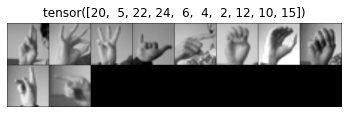

Prediction:


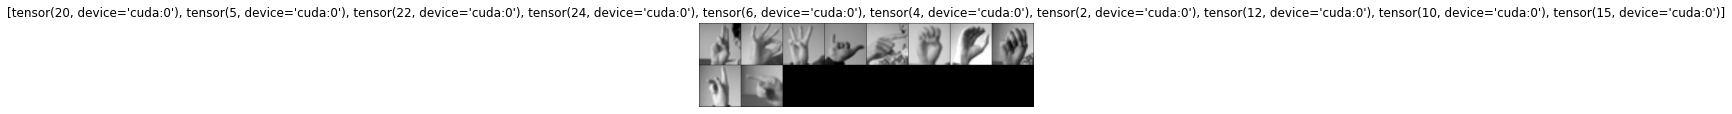

In [ ]:
visualize_model(vgg16) #test before training

In [21]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloader_train)
    val_batches = len(dataloader_test)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        i = 0
        vgg.train(True)
        
        for dummy, data in enumerate(dataloader_train):
            
            print("\rTraining batch {}/{}".format(i, train_batches/10 ), end='', flush=True)
            i = i+1    
            if (i > (train_batches/10)):
              break
            inputs, labels = data['image'],data['label']
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train /i
        avg_acc = acc_train /i
        
        vgg.train(False)
        vgg.eval()
            
        i = 0
        for dummy, data in enumerate(dataloader_test):
            
            print("\rValidation batch {}/{}".format(i, val_batches/10), end='', flush=True)
            i = i+1    
            inputs, labels = data['image'], data['label']
            
            if i > val_batches/10:
              break

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / i
        avg_acc_val = acc_val / i
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), 'VGG16_dataset110.pt')

Epoch 0/2
----------
Training batch 274/274.6
Validation batch 1/71.8

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Validation batch 71/71.8
Epoch 0 result: 
Avg loss (train): 1.0563
Avg acc (train): 6.0000
Avg loss (val): 1.1002
Avg acc (val): 7.0000
----------

Epoch 1/2
----------
Training batch 274/274.6
Validation batch 71/71.8
Epoch 1 result: 
Avg loss (train): 0.1819
Avg acc (train): 9.0000
Avg loss (val): 0.0571
Avg acc (val): 9.0000
----------


Training completed in 1m 57s
Best acc: 9.0000


In [ ]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 1/274.6tensor([10,  8, 20,  4,  1,  6, 13, 18, 10, 22], device='cuda:0')
Test batch 2/274.6tensor([21,  5,  4, 10, 14, 10, 11, 11, 23, 11], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test batch 3/274.6tensor([19,  7, 19,  4,  5,  2, 23,  0, 18, 18], device='cuda:0')
Test batch 4/274.6tensor([23,  6, 16, 11, 22,  7, 21,  5, 24,  3], device='cuda:0')
Test batch 5/274.6tensor([ 0, 23,  6,  6, 15,  8,  0, 10, 17, 14], device='cuda:0')
Test batch 6/274.6tensor([16, 11,  1, 10,  6,  0,  7,  0,  4,  7], device='cuda:0')
Test batch 7/274.6tensor([ 5, 11, 14, 23, 10, 15,  2, 11, 14,  6], device='cuda:0')
Test batch 8/274.6tensor([21, 21, 20,  3, 15, 21,  7, 18, 14, 22], device='cuda:0')
Test batch 9/274.6tensor([21, 17, 14, 17, 23,  1,  7, 11,  6, 19], device='cuda:0')
Test batch 10/274.6tensor([13, 22,  5, 17, 19,  7, 11, 14,  2, 10], device='cuda:0')
Test batch 11/274.6tensor([17, 23, 18, 10,  0, 19, 17, 21,  7, 22], device='cuda:0')
Test batch 12/274.6tensor([14, 24,  2, 23, 14, 17,  0, 12, 19, 20], device='cuda:0')
Test batch 13/274.6tensor([10,  1,  7, 18,  6, 19,  7, 15,  5, 15], device='cuda:0')
Test batch 14/274.6tensor([13,  5, 23, 10, 16,  0, 15,  8, 12, 22], devi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


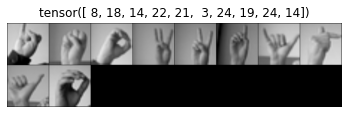

Prediction:


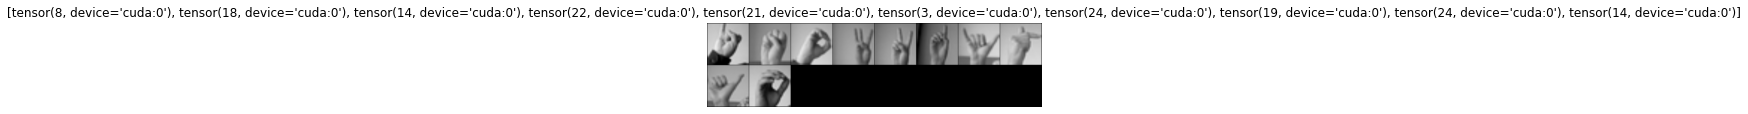

Ground truth:


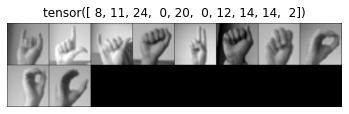

Prediction:


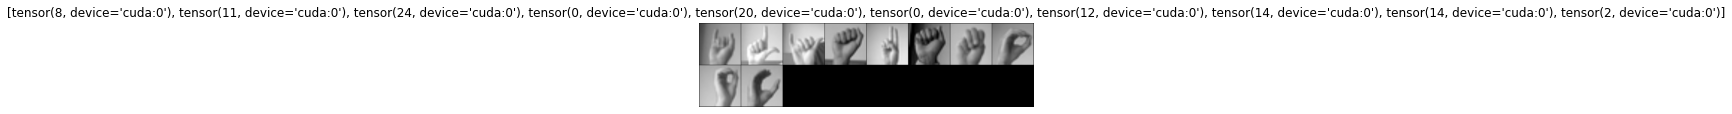

Ground truth:


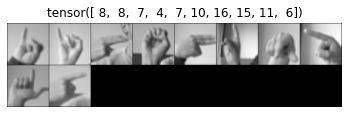

Prediction:


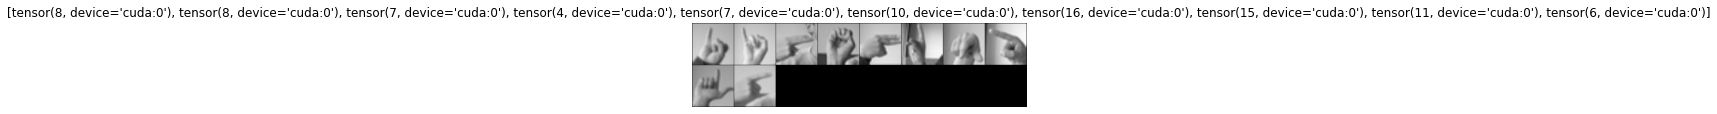

Ground truth:


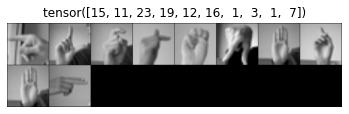

Prediction:


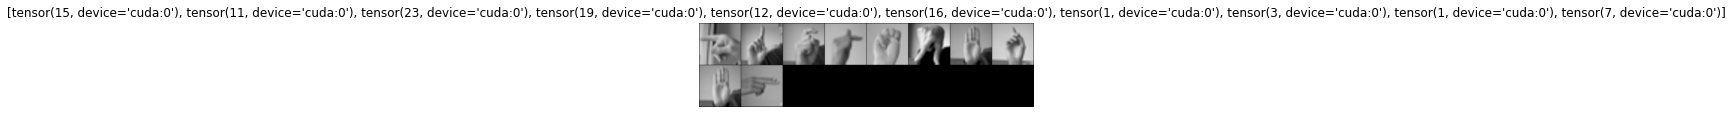

In [ ]:
visualize_model(vgg16, num_images=32)